## Build an image classifier with nothing but keywords

This is a fun little notebook that uses the [google-images-download](https://github.com/hardikvasa/google-images-download) python tool and the [fast.ai](https://github.com/fastai/fastai) pytorch library to create image classifiers by just using keywords.

## Prerequesites

Make sure you have pytorch and the fast.ai library installed and import the following:

In [1]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

If not already, uncomment the following line and install the download tool (available via pip):

In [3]:
#!pip install google_images_download

import the tool

In [20]:
from google_images_download import google_images_download

Set Path, image size and number of images to be downloaded

In [51]:
PATH = "/fastai/data/HotCornDogs/"
sz=224
nof_pics = 100

## Get the pics with keywords

First we'll instantiate the downloader class. The dictionary `arguments` holds our classes as keywords, the number of files we want per class and the directory where the pics should be saved. If you want to download more than 100 images per class you have to install chrome. Adapt that to your needs!

In [52]:
response = google_images_download.googleimagesdownload()

arguments = {"keywords":"Hot Dog,Corn Dog",
             "limit":nof_pics,
             "print_urls":False,
             "output_directory":f'{PATH}train'}

paths = response.download(arguments)





Item no.: 1 --> Item name = Hot Dog
Evaluating...
Starting Download...
Completed Image ====> 1. retrieve.cfm
Completed Image ====> 2. 769071-960x720-hot-dog.jpg
Completed Image ====> 3. mcdonalds-hot-dog-220027-detailp.jpeg
Completed Image ====> 4. hot-dog-06.jpg
Completed Image ====> 5. maxresdefault.jpg
Completed Image ====> 6. 13521_1-1_334-334@2x.jpg
Completed Image ====> 7. recipe_hot-dog-sandwich.jpg
Completed Image ====> 8. italian-style-hotdog-adventskalender-wurstler.jpg
Completed Image ====> 9. ,id=137ca8c8,b=lecker,w=610,cg=c.jpg
Completed Image ====> 10. hotdog_mit_bacon.jpg
Completed Image ====> 11. 1200px-germanvegetariansausage.jpg
Completed Image ====> 12. hot-dog-new-york.jpg
Completed Image ====> 13. hot-dog-race-cars-9724-800x533.jpg
Completed Image ====> 14. f214_foodboom_laugen%20hot%20dog%20mit%20senfcreme_klein_v1.jpg
Completed Image ====> 15. 943911-960x720-cheeseburger-hot-dog.jpg
Completed Image ====> 16. 4940.jpg
Completed Image ====> 17. hotdog-klassisch_pi

Completed Image ====> 35. state-fair-corn-dogs-9.jpg
Completed Image ====> 36. 51pej6ge-dl._sx355_.jpg
Completed Image ====> 37. 100-polyester-yummy-world-medium-corn-dog-plush-1_2048x.jpg
Completed Image ====> 38. corndog-3.jpg
Completed Image ====> 39. img-foot_long_corn_dog.jpg
Completed Image ====> 40. ct-food-chicago-corn-dog-cozy-dog-drive-in-20180301.jpg
Completed Image ====> 41. corn-dog-mini-muffins-0476.jpg
Completed Image ====> 42. amerikanische-corn-dogs.jpg
Completed Image ====> 43. 1386172255684.jpeg
Completed Image ====> 44. veggie-corn-dogs.jpg
Completed Image ====> 45. mini-corn-dogs-10.jpg
Completed Image ====> 46. corndog_outside.jpg
Completed Image ====> 47. img_6890.jpg
Completed Image ====> 48. 2014-06-09-corn-dogs-005-1280x720.jpg
Completed Image ====> 49. 739822-960x720-corn-dogs.jpg
Completed Image ====> 50. gluten-free-corn-dog-bites-2.jpg
Completed Image ====> 51. minicorndogmuffins-iowagirleats.jpg
Completed Image ====> 52. baked-corn-dogs1.jpg
Completed Ima

## Extract validation set

Now we need a little function to extract a validation set:

In [53]:
def make_val_set(PATH, nof_val_pics):
    if not os.path.exists(f'{PATH}valid'):
        os.makedirs(f'{PATH}valid')
        for pic_class in os.listdir(f'{PATH}train'):
            os.makedirs(f'{PATH}valid/{pic_class}')
            for pic in random.sample(os.listdir(f'{PATH}train/{pic_class}'), nof_val_pics):
                os.rename(f'{PATH}train/{pic_class}/{pic}', 
                          f'{PATH}valid/{pic_class}/{pic}')
    else:
        warnings.warn("The validation folder already exists! No validation set created.")

Create the validation set:

In [54]:
make_val_set(PATH, 4)

In [58]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy        
    0      0.951026   0.82916    0.5       
    1      0.747507   0.489346   0.875           
    2      0.615505   0.38153    0.875           



[array([0.38153]), 0.875]

## Plot some pics

In [60]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [61]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [62]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [63]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [64]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [65]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct Corn Dogs


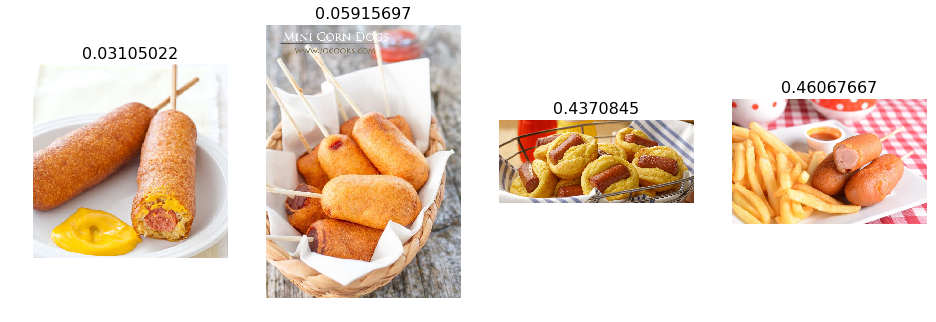

In [67]:
plot_val_with_title(most_by_correct(0, True), "Most correct Corn Dogs")

Most correct Hot Dogs


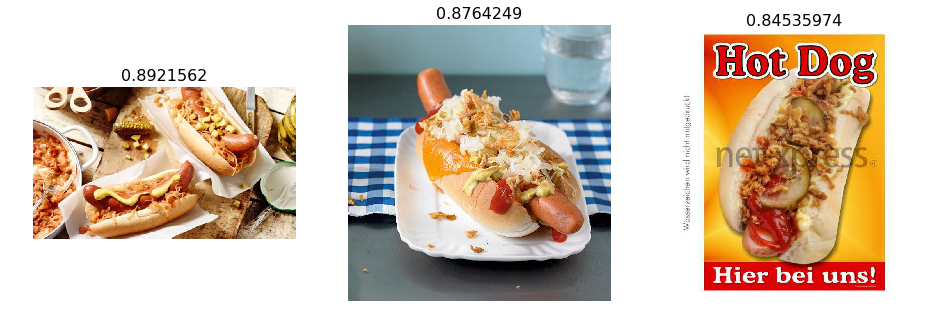

In [68]:
plot_val_with_title(most_by_correct(1, True), "Most correct Hot Dogs")